**This is the adaptive version of the original DemoNotebook.ipynb for google colab and adjustment to file export structure by JW 071425**

In [1]:
# Install geospatial dependencies
!pip install geopandas rasterio rioxarray shapely pyproj fiona xarray rasterstats scikit-image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 36.9 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys
sys.path.append('/content/drive/MyDrive/gridflow-add-region-subregion-support')

In [4]:
import geopandas as gpd
import pandas as pd
import rasterio
from rasterio.features import shapes
import rioxarray
import matplotlib.pyplot as plt
import numpy as np
from skimage.segmentation import slic
from shapely.geometry import shape
from rasterstats import zonal_stats

%matplotlib inline

%load_ext autoreload
%autoreload 2

from gridflow import model
from gridflow.visuals import country_viz

### Demo notebook
This notebook demonstrates the capabilities of the gridflow package.

In [5]:
lux = model.region("luxembourg", data_path="/content/drive/MyDrive/gridflow-add-region-subregion-support/data/LUX")

In [6]:
lux.create_subregions(n=5)
lux.create_network()

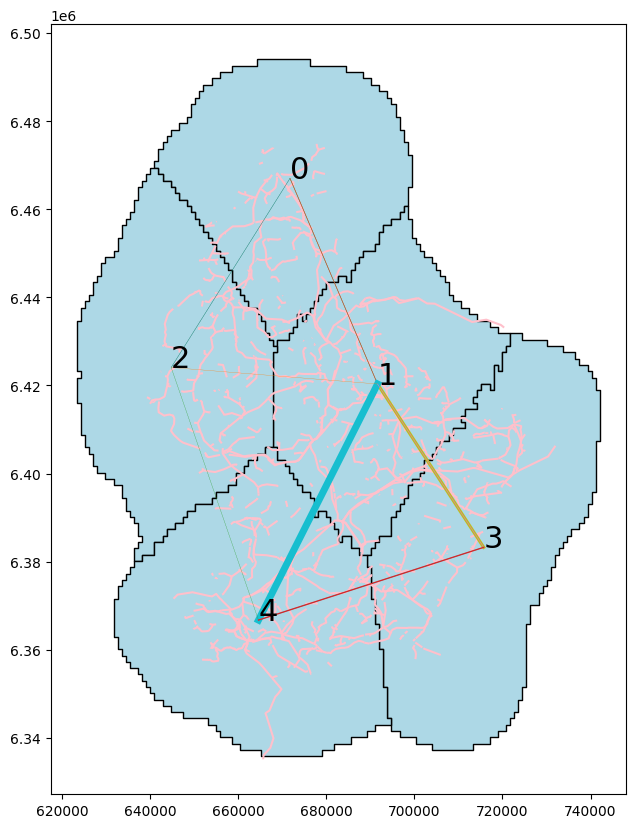

In [9]:
country_viz(lux)

In [10]:
# 2. Generate EPM inputs
raw_inputs_path = "/content/drive/MyDrive/gridflow-add-region-subregion-support/data/epm_inputs_raw/load"
epm_inputs = lux.generate_epm_inputs(raw_inputs_path)

Using 5 spatially-defined subregions

Processing pDemandForecast.csv...
  Original shape: (2, 29)
  Final shape: (10, 29) (5 subregions × 2 original rows)

Processing pEnergyEfficiencyFactor.csv...
  Original shape: (0, 29)
  Final shape: (0, 29) (5 subregions × 0 original rows)

Processing sRelevant.csv...
  Original shape: (0, 1)
  No 'zone' column found, keeping original data

Processing pDemandData.csv...
  Original shape: (0, 25)
  Final shape: (0, 25) (5 subregions × 0 original rows)

Processing pDemandProfile.csv...
  Original shape: (365, 27)
  Final shape: (1825, 27) (5 subregions × 365 original rows)


In [12]:
# 3. Check pDemandProfile
if 'pDemandProfile' in epm_inputs:
    df = epm_inputs['pDemandProfile']
    print(f"Original CSV: 365 rows")
    print(f"Subregions created: {len(lux.subregions)}")
    print(f"Final CSV: {len(df)} rows")
    print(f"365 × {len(lux.subregions)} = {365 * len(lux.subregions)}")
    print(f"Correct: {len(df) == 365 * len(lux.subregions)}")

    # Check unique zones (which are now subregion indices)
    unique_zones = sorted(df['zone'].unique())
    print(f"\nUnique zones (subregion indices): {unique_zones}")
    print(f"Expected subregion indices: {lux.subregions.index.tolist()}")
    print(f"Zones match subregions: {unique_zones == lux.subregions.index.tolist()}")

    # Show sample
    print("\nFirst 10 rows:")
    print(df[['zone', 'd', 't1', 't2']].head(10))

    # Show distribution across zones
    print("\nRows per zone (subregion):")
    print(df['zone'].value_counts().sort_index())

    # Save to new CSV
    output_path = "/content/drive/MyDrive/gridflow-add-region-subregion-support/data/epm_inputs_processed/load"
    import os
    os.makedirs(output_path, exist_ok=True)

    output_file = os.path.join(output_path, "pDemandProfile_processed.csv")
    df.to_csv(output_file, index=False)
    print(f"\nSaved to: {output_file}")

Original CSV: 365 rows
Subregions created: 5
Final CSV: 1825 rows
365 × 5 = 1825
Correct: True

Unique zones (subregion indices): [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
Expected subregion indices: [0, 1, 2, 3, 4]
Zones match subregions: True

First 10 rows:
   zone    d        t1        t2
0     0   d1  0.596154  0.532051
1     0   d2  0.589744  0.544872
2     0   d3  0.589744  0.551282
3     0   d4  0.641026  0.564103
4     0   d5  0.608974  0.576923
5     0   d6  0.628205  0.576923
6     0   d7  0.621795  0.583333
7     0   d8  0.589744  0.551282
8     0   d9  0.532051  0.532051
9     0  d10  0.589744  0.538462

Rows per zone (subregion):
zone
0    365
1    365
2    365
3    365
4    365
Name: count, dtype: int64

Saved to: /content/drive/MyDrive/gridflow-add-region-subregion-support/data/epm_inputs_processed/load/pDemandProfile_processed.csv
